In [64]:
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from karateclub import Graph2Vec
import os

## Toy Example
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [2]:
X = np.random.normal(size=(1000, 3))
X_embedded = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=5
).fit_transform(X)

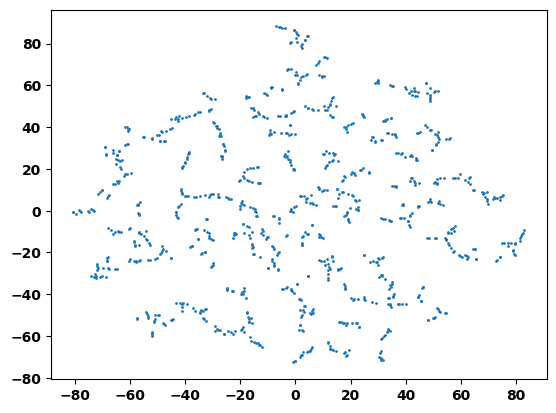

In [3]:
x = X_embedded[:, 0]
y = X_embedded[:, 1]
plt.scatter(x, y, s=1)

In [4]:
# apply a function
def f(x, y, z):
    return np.array([
        x * y + z,
        y - z, 
        5 * z * (x ** 2)
    ])
Xf = f(X[:, 0], X[:, 1], X[:, 2])

In [5]:
Xf_embedded = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=10
).fit_transform(Xf.transpose())

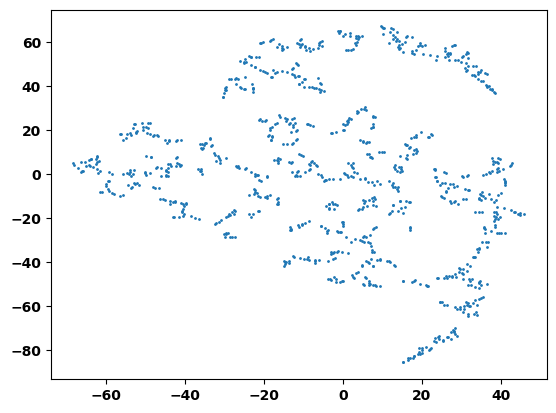

In [6]:
x = Xf_embedded[:, 0]
y = Xf_embedded[:, 1]
plt.scatter(x, y, s=1)

## GraphRNN Visualization

In [43]:
# load models
from models.generator import * 
from models.inverter import * 
from models.discriminator import * 
from models.dataset import * 
from models.args import *

args = Args()
# populate arguments 
train, labels = get_dataset_with_label(args.graph_type) # entire dataset as train
args.batch_size = 512
train_dataset = Graph_sequence_sampler_pytorch(train, labels, args)
train_loader, adj_shape = get_dataloader_labels(train_dataset, args)
noise_dim = args.hidden_size_rnn
netG = GraphRNN(args=args)
netI = Inverter(input_dim=512, output_dim=args.hidden_size_rnn, hidden_dim=256)
netD = TestNN(adj_shape[0]*adj_shape[1], 1)

# load weights 
netG.load_state_dict(torch.load("./cache/graphrnn/saved_model/generator.pth"))
netI.load_state_dict(torch.load("./cache/graphrnn/saved_model/inverter.pth"))
netD.load_state_dict(torch.load("./cache/graphrnn/saved_model/discriminator.pth"))

calculating max previous node, total iteration: 12000
iter 0 times
iter 2400 times
iter 4800 times
iter 7200 times
iter 9600 times
max previous node: 10


<All keys matched successfully>

In [62]:
def load_data_n_models(args, num_data=512): 
    # populate arguments 
    train, labels = get_dataset_with_label(args.graph_type) # entire dataset as train
    args.batch_size = num_data
    train_dataset = Graph_sequence_sampler_pytorch(train, labels, args)
    train_loader, adj_shape = get_dataloader_labels(train_dataset, args)
    noise_dim = args.hidden_size_rnn
    netG = GraphRNN(args=args)
    netI = Inverter(input_dim=512, output_dim=args.hidden_size_rnn, hidden_dim=256)
    netD = TestNN(adj_shape[0]*adj_shape[1], 1)

    # load weights 
    netG.load_state_dict(torch.load("./cache/graphrnn/saved_model/generator.pth"))
    netI.load_state_dict(torch.load("./cache/graphrnn/saved_model/inverter.pth"))
    netD.load_state_dict(torch.load("./cache/graphrnn/saved_model/discriminator.pth"))
    netI.eval()
    netG.eval()
    netD.eval()
    return netG, netI, netD, train_loader

In [44]:
# visualization #1
# outline
# assumption: GraphRNN samples and data are available.
# 1. use TSNE to visualize latent space (Shouldn't this be the last step? Because we need the real and the genearted graphs first)
# 2. train graph2vec on true vs generated samples
# 3. use graph2vec to embed GraphRNN samples and true data in some (high-dimensional) Euclidean space
# 4. use TSNE to visualize those embeddings

# optional:
# color points in (4) and (1) depending on the number of nodes, (continuous) shade based on average degree, etc 

# a total of 4 plots 
netI.eval()
netG.eval()
netD.eval()

# get padded data
real_data = list(train_loader)[0]['adj_mat'].numpy() # (8, 29, 29)
real_data = [nx.from_numpy_matrix(real) for real in real_data]

# train graph2vec on real samples 
from karateclub import Graph2Vec
g2v_real = Graph2Vec(dimensions=512, workers=-1)
g2v_real.fit(real_data)
real_embeddings = g2v_real.get_embedding()

# generate samples 
gen_latent = np.random.randn(args.batch_size, 1, args.hidden_size_rnn) # latent space representation
gen_data = []
for i in range(args.batch_size): 
    input = torch.tensor(gen_latent[i]).float()
    gen_data.append(netG.generate(input)[0])
gen_data = [nx.from_numpy_matrix(gen.numpy()) for gen in gen_data]
g2v_gen = Graph2Vec(dimensions=512, workers=-1)
g2v_gen.fit(gen_data)
gen_embeddings = g2v_gen.get_embedding()

# get the latent representation the real graph 
real_latent = netI(torch.Tensor(real_embeddings).float()).detach().numpy()
gen_latent = gen_latent[:, 0, :]

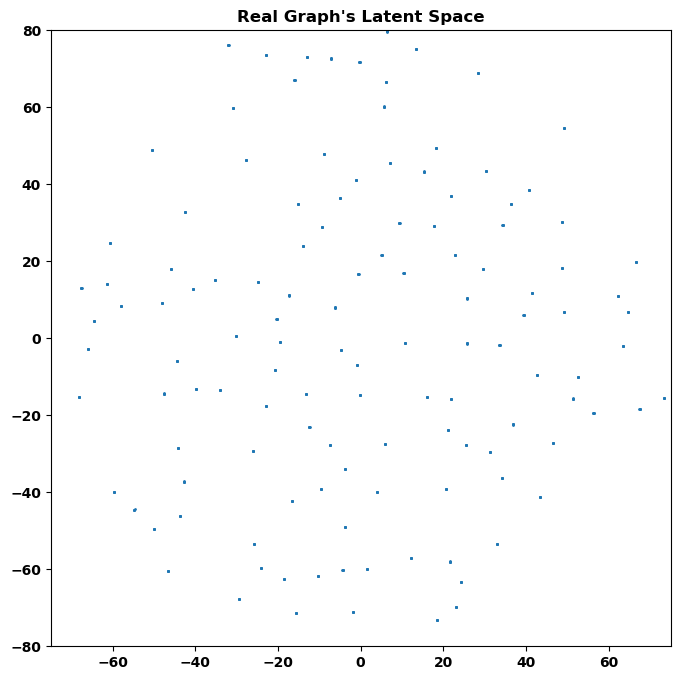

In [65]:
# real, latent
real_latent_embed = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=5
).fit_transform(real_latent.reshape(args.batch_size, -1))
x = real_latent_embed[:, 0]
y = real_latent_embed[:, 1]
plt.figure(figsize=(8,8))
plt.xlim(-75, 75)
plt.ylim(-80, 80)
plt.scatter(x, y, s=1)
plt.title("Real Graph's Latent Space")

if not os.path.exists(args.graph_save_path): 
    os.makedirs(args.graph_save_path)
plt.savefig(args.graph_save_path+"real_latent.png")

Text(0.5, 1.0, "Real Graph's Embedding Space")

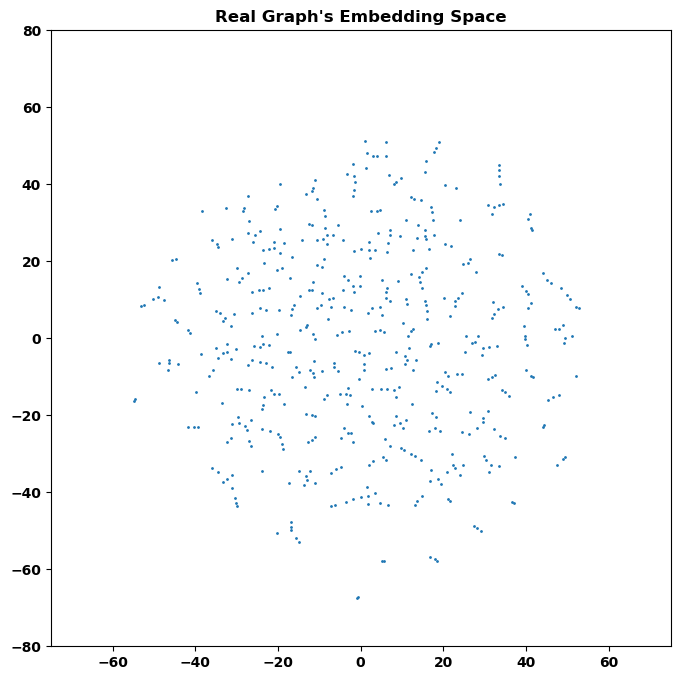

In [59]:
# real, embedding 
real_embeddings_embed = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=5
).fit_transform(real_embeddings.reshape(args.batch_size, -1))
x = real_embeddings_embed[:, 0]
y = real_embeddings_embed[:, 1]
plt.figure(figsize=(8,8))
plt.xlim(-75, 75)
plt.ylim(-80, 80)
plt.scatter(x, y, s=1)
plt.title("Real Graph's Embedding Space")

Text(0.5, 1.0, "Generated Graph's Latent Space")

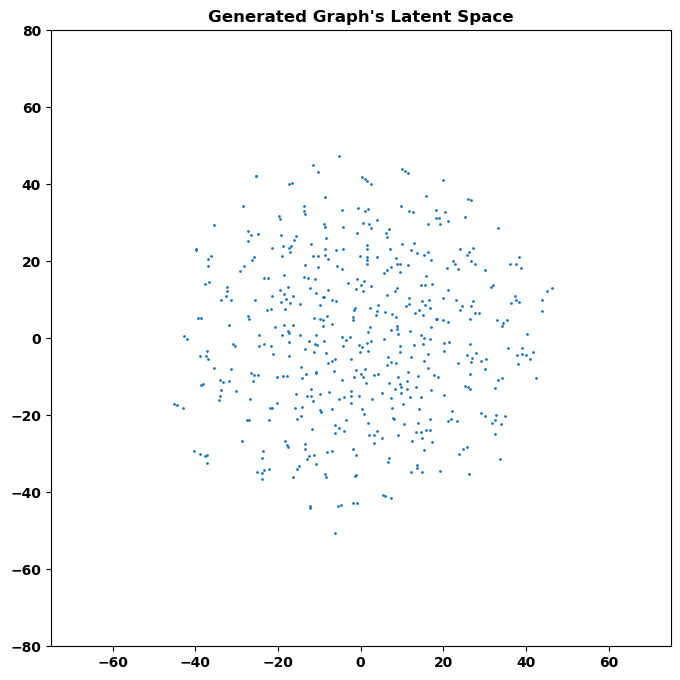

In [58]:
# generated, latent
gen_latent_embed = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=5
).fit_transform(gen_latent.reshape(args.batch_size, -1))
x = gen_latent_embed[:, 0]
y = gen_latent_embed[:, 1]
plt.figure(figsize=(8,8))
plt.xlim(-75, 75)
plt.ylim(-80, 80)
plt.scatter(x, y, s=1)
plt.title("Generated Graph's Latent Space")

Text(0.5, 1.0, "Generated Graph's Embedding Space")

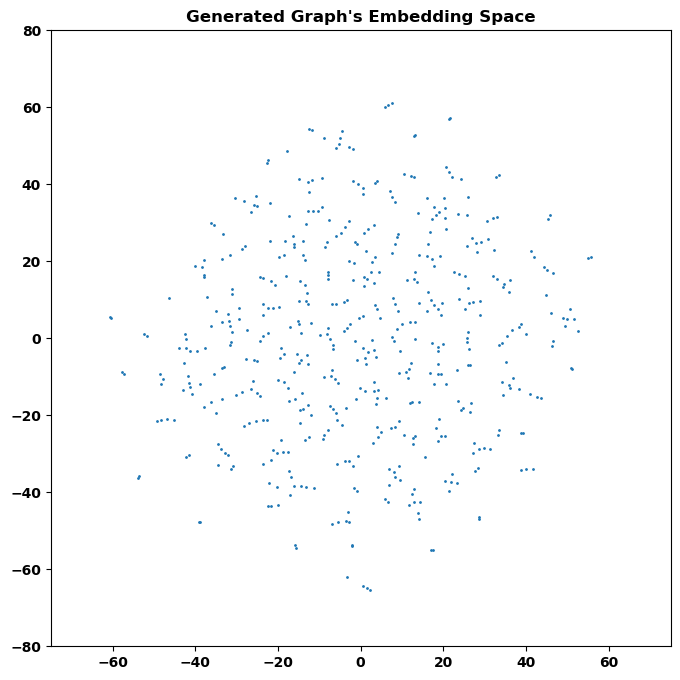

In [61]:
# generated, embedding
gen_embeddings_embed = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=5
).fit_transform(gen_embeddings.reshape(args.batch_size, -1))
x = gen_embeddings_embed[:, 0]
y = gen_embeddings_embed[:, 1]
plt.figure(figsize=(8,8))
plt.xlim(-75, 75)
plt.ylim(-80, 80)
plt.scatter(x, y, s=1)
plt.title("Generated Graph's Embedding Space")

In [ ]:
def get_tsne_plots(args, num_of_datapoints=512):
    """Generate the TSNE plots with labels"""    
    # get padded data
    real_data = list(train_loader)[0]['adj_mat'].numpy() # (8, 29, 29)
    real_data = [nx.from_numpy_matrix(real) for real in real_data]

    # train graph2vec on real samples 
    g2v_real = Graph2Vec(dimensions=512, workers=-1)
    g2v_real.fit(real_data)
    real_embeddings = g2v_real.get_embedding()

    # generate samples 
    gen_latent = np.random.randn(args.batch_size, 1, args.hidden_size_rnn) # latent space representation
    gen_data = []
    for i in range(args.batch_size): 
        input = torch.tensor(gen_latent[i]).float()
        gen_data.append(netG.generate(input)[0])
    gen_data = [nx.from_numpy_matrix(gen.numpy()) for gen in gen_data]
    g2v_gen = Graph2Vec(dimensions=512, workers=-1)
    g2v_gen.fit(gen_data)
    gen_embeddings = g2v_gen.get_embedding()

    # get the latent representation the real graph 
    real_latent = netI(torch.Tensor(real_embeddings).float()).detach().numpy()
    gen_latent = gen_latent[:, 0, :] 

    # real, latent
    real_latent_embed = TSNE(
        n_components=2, learning_rate='auto',
        init='random', perplexity=5
    ).fit_transform(real_latent.reshape(args.batch_size, -1))
    x = real_latent_embed[:, 0]
    y = real_latent_embed[:, 1]
    plt.figure(figsize=(8,8))
    plt.xlim(-75, 75)
    plt.ylim(-80, 80)
    plt.scatter(x, y, s=1)
    plt.title("Real Graph's Latent Space")
    if not os.path.exists(args.graph_save_path): 
        os.makedirs(args.graph_save_path)
    plt.savefig(args.graph_save_path+"real_latent.png")

    # real, embedding 
    real_embeddings_embed = TSNE(
        n_components=2, learning_rate='auto',
        init='random', perplexity=5
    ).fit_transform(real_embeddings.reshape(args.batch_size, -1))
    x = real_embeddings_embed[:, 0]
    y = real_embeddings_embed[:, 1]
    plt.figure(figsize=(8,8))
    plt.xlim(-75, 75)
    plt.ylim(-80, 80)
    plt.scatter(x, y, s=1)
    plt.title("Real Graph's Embedding Space")
    if not os.path.exists(args.graph_save_path): 
        os.makedirs(args.graph_save_path)
    plt.savefig(args.graph_save_path+"real_embeddings.png")

    # generated, latent
    gen_latent_embed = TSNE(
        n_components=2, learning_rate='auto',
        init='random', perplexity=5
    ).fit_transform(gen_latent.reshape(args.batch_size, -1))
    x = gen_latent_embed[:, 0]
    y = gen_latent_embed[:, 1]
    plt.figure(figsize=(8,8))
    plt.xlim(-75, 75)
    plt.ylim(-80, 80)
    plt.scatter(x, y, s=1)
    plt.title("Generated Graph's Latent Space")
    if not os.path.exists(args.graph_save_path): 
        os.makedirs(args.graph_save_path)
    plt.savefig(args.graph_save_path+"gen_latent.png")

    # generated, embedding
    gen_embeddings_embed = TSNE(
        n_components=2, learning_rate='auto',
        init='random', perplexity=5
    ).fit_transform(gen_embeddings.reshape(args.batch_size, -1))
    x = gen_embeddings_embed[:, 0]
    y = gen_embeddings_embed[:, 1]
    plt.figure(figsize=(8,8))
    plt.xlim(-75, 75)
    plt.ylim(-80, 80)
    plt.scatter(x, y, s=1)
    plt.title("Generated Graph's Embedding Space")
    if not os.path.exists(args.graph_save_path): 
        os.makedirs(args.graph_save_path)
    plt.savefig(args.graph_save_path+"gen_embeddings.png")

In [ ]:
# visualization #2 
# outline 
# 1. get true data sample from dataset (MUTAG, PROTEIN, ENZYME, etc)
# 2. generate the same amount of samples as the dataset 
# 3. calculate degree distribution, clustering coefficient, and betweenness coefficient (optional) of real and generated graph 
# 4. plot the distribution of the two measurements on the same plot 

In [ ]:
# visualization #3
# outline
# 1. plot training loss of netD, netG, and netI on the same graph

# read loss 
lossI_fp = "cache/graphrnn/loss_results/inverter_loss.txt"
lossD_fp = "cache/graphrnn/loss_results/discriminator_loss.txt"
lossG_fp = "cache/graphrnn/loss_results/generator_loss.txt"

lossI = np.loadtxt(lossI_fp)
lossD = np.loadtxt(lossD_fp)
lossG = np.loadtxt(lossG_fp)

In [ ]:
# check size 
assert len(lossI) == len(lossD) == len(lossG)
epochs = range(len(lossI))

figure = plt.figure()
